# IMPORTANT: As this was just an assignment to be done in 1 hour I have only trained for 1 epoch hence the low accuracy because of the fact that deep learning models tend to take hours to train and dataset was used from kaggle as it was too large to be downloaded locally

# Dataset used was open source and was provided by Makerere AI Lab 

# link to the dataset https://www.kaggle.com/c/cassava-leaf-disease-classification/data

# Importing Libraries

In [1]:
import cv2
import json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
BASE_DIR = '../input/cassava-leaf-disease-classification'

In [5]:
df = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))

# Training Parameters - Epochs, Image-Size, Batch-Size

In [23]:
BATCH_SIZE = 24
EPOCHS = 2
TARGET_SIZE = 200

# Data Augmentation

In [8]:
df.label = df.label.astype('str')

train_datagen = ImageDataGenerator(featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   validation_split = 0.25,
                                   rotation_range = 20,
                                   zoom_range = 0.25,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest',
                                   height_shift_range = 0.1,
                                   width_shift_range = 0.1)


train_generator = train_datagen.flow_from_dataframe(df,
                         directory = os.path.join(BASE_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

validation_datagen = ImageDataGenerator(validation_split = 0.25)

validation_generator = validation_datagen.flow_from_dataframe(df,
                         directory = os.path.join(BASE_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 16048 validated image filenames belonging to 5 classes.
Found 5349 validated image filenames belonging to 5 classes.


# EDA

# Visualize few augmentations

Found 1 validated image filenames belonging to 1 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


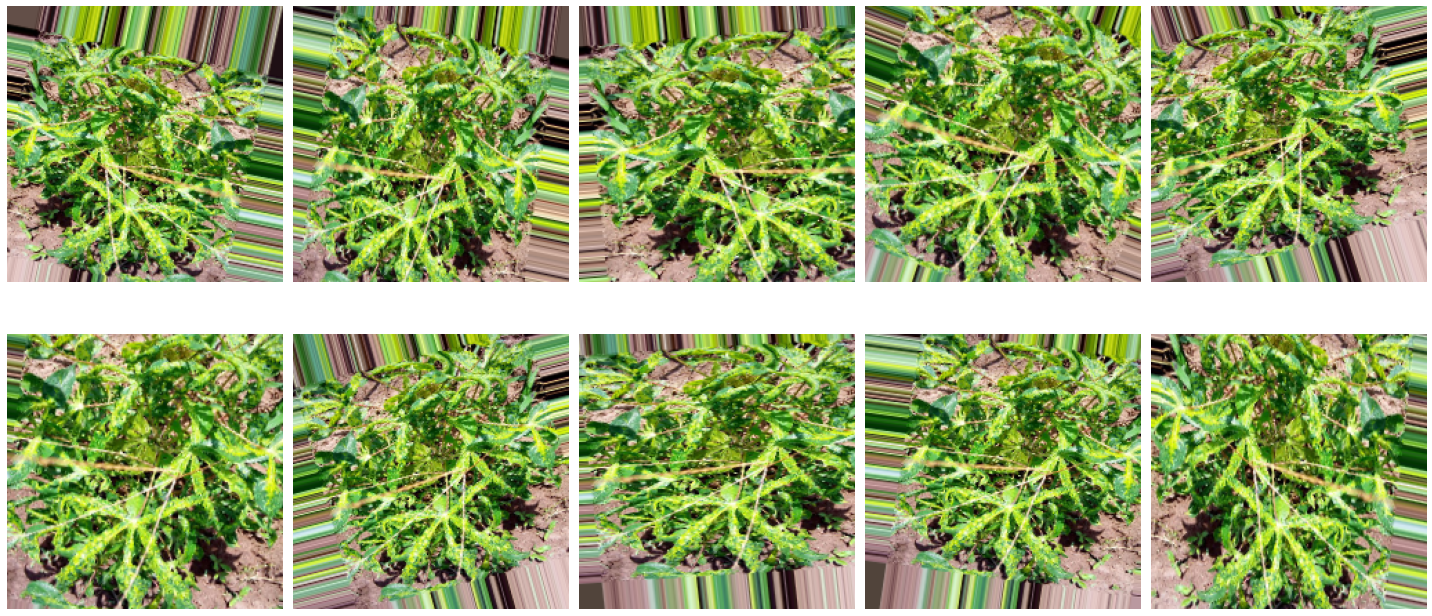

In [9]:
generator = train_datagen.flow_from_dataframe(df.iloc[21:22],
                         directory = os.path.join(BASE_DIR, "train_images"),
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

aug_images = [generator[0][0][0]/255 for i in range(10)]
fig, axes = plt.subplots(2, 5, figsize = (20, 10))
axes = axes.flatten()
for img, ax in zip(aug_images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

# Creating the Model

In [13]:
# model = Sequential()
# model.add(Conv2D(32, (3, 3), input_shape=(200, 200, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))



def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(200, 200, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten()) 
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    # COMPILE
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [14]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
activation_5 (Activation)    (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 97, 97, 32)        9248      
_________________________________________________________________
activation_6 (Activation)    (None, 97, 97, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 46, 46, 64)       

# Training the model with callbacks - Checkpoint, EarlyStopping & Reduce_lr

In [17]:
checkpoint = ModelCheckpoint('CNN.h5', save_best_only = True, monitor = 'val_loss', mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, mode = 'min', verbose = 1, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 3, min_delta = 0.001, mode = 'min', verbose = 1)


history = model.fit(train_generator, epochs = EPOCHS, validation_data = validation_generator, validation_steps = 200, callbacks = [checkpoint, early_stop, reduce_lr])

669/669 [==============================] - ETA: 0s - loss: -37813156315136.0000 - accuracy: 0.1026
Epoch 00001: val_loss improved from inf to -193420043747328.00000, saving model to CNN.h5
669/669 [==============================] - 739s 1s/step - loss: -37813156315136.0000 - accuracy: 0.1026 - val_loss: -193420043747328.0000 - val_accuracy: 0.1015


# Model Performance Graphs

## Accuracy Graph

In [ ]:
history.history

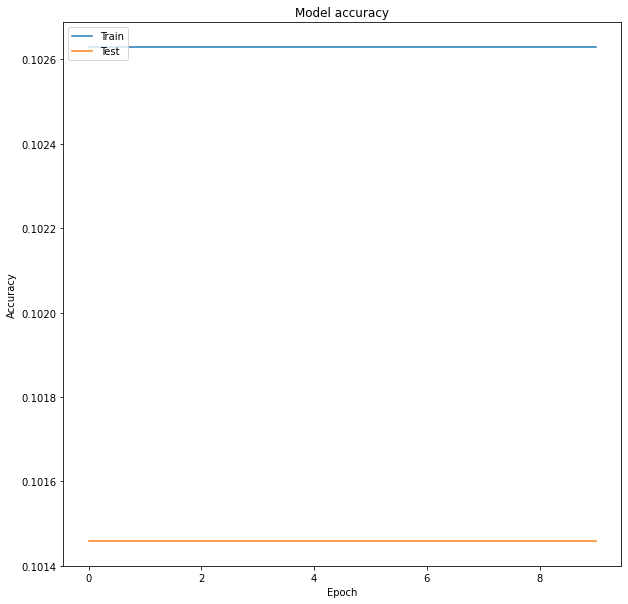

In [31]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy']*10)
plt.plot(history.history['val_accuracy']*10)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Loss Graph

In [ ]:
history.history['loss']

In [ ]:
plt.figure(figsize=(20, 20))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Visualizing the GradCam at the intermediate Layers

In [37]:
def visualize_activation(image, activation_layer = 0, layers = 10):
    
    layer_outputs = [layer.output for layer in model.layers[:layers]]
    activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
    activations = activation_model.predict(image)
    
    rows = int(activations[activation_layer].shape[3] / 3)
    cols = int(activations[activation_layer].shape[3] / rows)
    
    fig, axes = plt.subplots(rows, cols, figsize = (15, 15 * cols))
    axes = axes.flatten()
    
    for i, ax in zip(range(activations[activation_layer].shape[3]), axes):
        
        ax.matshow(activations[activation_layer][0, :, :, i], cmap = 'viridis')
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

In [38]:
img_path = os.path.join(BASE_DIR, "train_images", df.image_id[40])
img = image.load_img(img_path, target_size = (TARGET_SIZE, TARGET_SIZE))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.

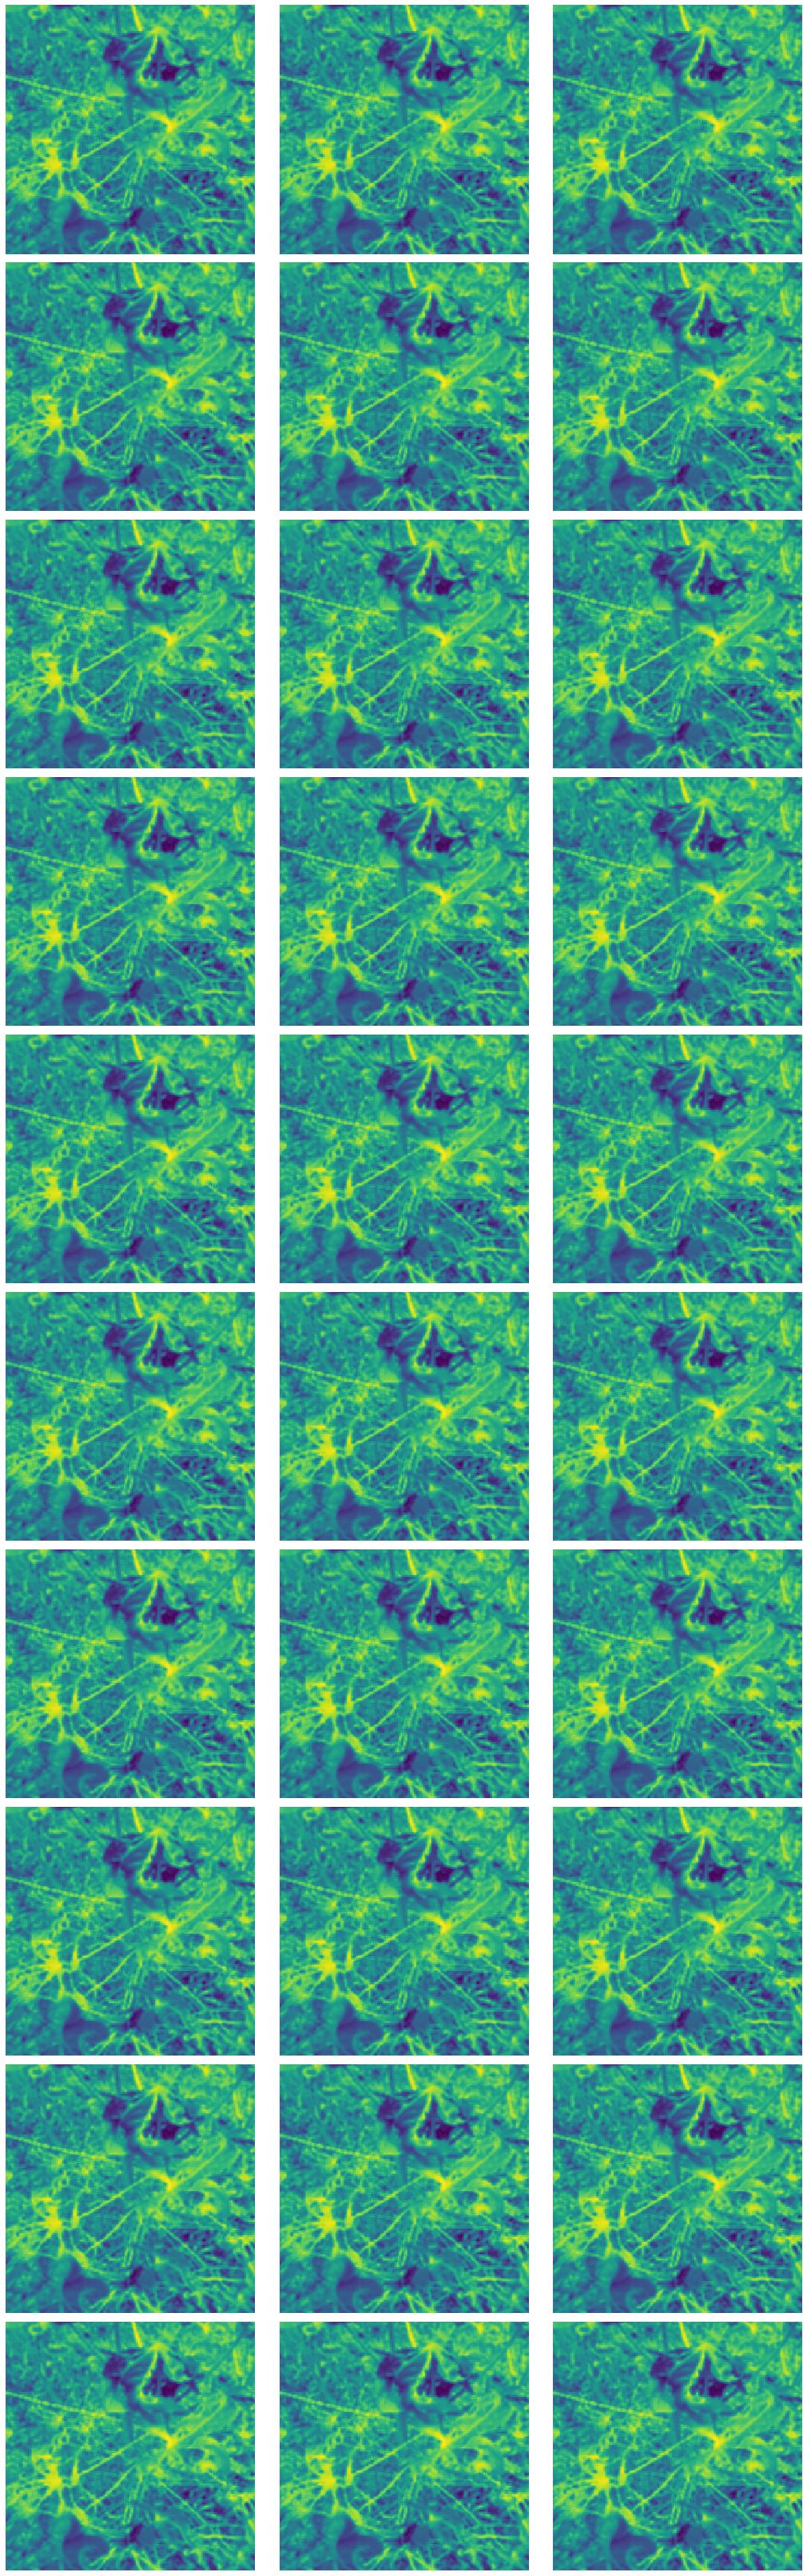

In [39]:
# 0th Layer
visualize_activation(img_tensor, 0)

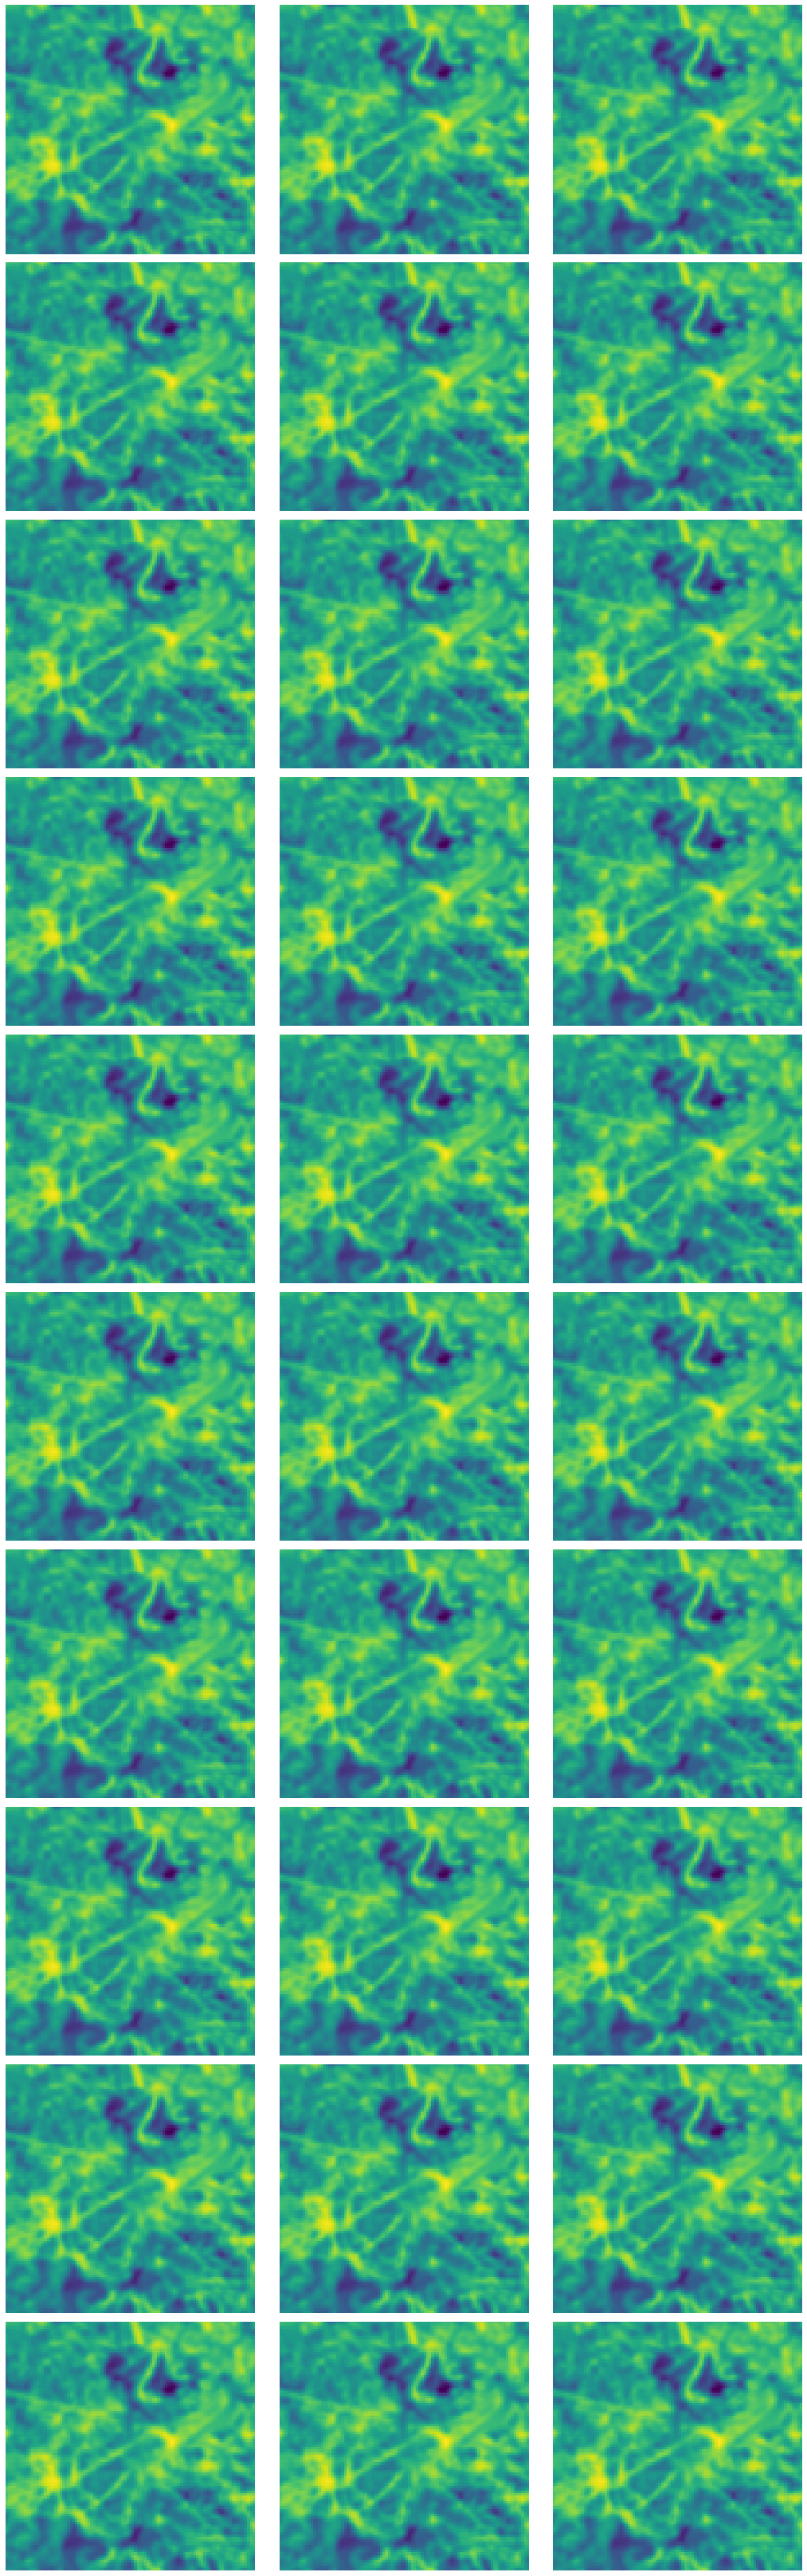

In [40]:
# 10th Layer
visualize_activation(img_tensor, 4)

In [ ]:
def all_activations_vis(img, layers = 10):
    layer_outputs = [layer.output for layer in model.layers[:layers]]
    activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
    activations = activation_model.predict(img)
    
    layer_names = []
    for layer in model.layers[:layers]: 
        layer_names.append(layer.name) 

    images_per_row = 3
    for layer_name, layer_activation in zip(layer_names, activations): 
        n_features = layer_activation.shape[-1] 

        size = layer_activation.shape[1] 

        n_cols = n_features // images_per_row 
        display_grid = np.zeros((size * n_cols, images_per_row * size)) 

        for col in range(n_cols): 
            for row in range(images_per_row): 
                channel_image = layer_activation[0, :, :, col * images_per_row + row] 
                channel_image -= channel_image.mean() 
                channel_image /= channel_image.std() 
                channel_image *= 64 
                channel_image += 128 
                channel_image = np.clip(channel_image, 0, 255).astype('uint8') 
                display_grid[col * size : (col + 1) * size, 
                             row * size : (row + 1) * size] = channel_image 
        scale = 1. / size 
        plt.figure(figsize=(scale * 5 * display_grid.shape[1], 
                            scale * 5 * display_grid.shape[0])) 
        plt.title(layer_name) 
        plt.grid(False)
        plt.axis('off')
        plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

In [ ]:
all_activations_vis(img_tensor, 5)

In [26]:
submit=pd.DataFrame()
submit['image_id']='2216849948.jpg'
submit['label']=4

submit

Empty DataFrame
Columns: [image_id, label]
Index: []

## Running Predictions

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

preds = []

for image_id in submit.image_id:
    
    image = load_img(os.path.join(BASE_DIR, "test_images", image_id), target_size = (TARGET_SIZE, TARGET_SIZE))
    
    #Image Processes & Reshaping
    image = img_to_array(image)    
    image = image.reshape(1, TARGET_SIZE, TARGET_SIZE, 3)

    #Center Pixel Data & Normalize into float
    image = image.astype('float32')
    preds.append(np.argmax(model.predict(image)))

submit['label'] = preds

## Exporting the submission.csv file

In [ ]:


submit.to_csv('submission.csv', index = False)